In [2]:
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f283/download/420938113-1629960298/mvtec_anomaly_detection.tar.xz

--2025-12-18 16:46:59--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f283/download/420938113-1629960298/mvtec_anomaly_detection.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5264982680 (4.9G) [application/x-xz]
Saving to: ‘mvtec_anomaly_detection.tar.xz’

mvtec_anomaly_detec 100%[===================>]   4.90G  13.6MB/s    in 6m 13s  

2025-12-18 16:53:13 (13.5 MB/s) - ‘mvtec_anomaly_detection.tar.xz’ saved [5264982680/5264982680]



In [3]:
!tar -xf /content/mvtec_anomaly_detection.tar.xz

In [ ]:
!pip install -q diffusers==0.30.0 transformers accelerate safetensors opensimplex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 6.9 MB/s eta 0:00:00


In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# Creating a basic UNet with sinusoidal time embeddings that help predict noise
# credits: https://apxml.com/courses/advanced-diffusion-architectures/chapter-2-advanced-unet-architectures/unet-time-embeddings


class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: [B] (int or float timesteps)
        returns: [B, dim]
        """
        device = t.device
        half_dim = self.dim // 2
        # [half_dim]
        freqs = torch.exp(
            torch.arange(half_dim, device=device) * (-math.log(10000.0) / (half_dim - 1))
        )
        # [B, 1] * [half_dim] -> [B, half_dim]
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        # [B, dim]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        return emb


# --------- Building blocks ---------

class DoubleConv(nn.Module):
    """
    (Conv -> Norm -> ReLU) x2 with optional time embedding.
    in_ch -> out_ch
    """
    def __init__(self, in_ch: int, out_ch: int, time_dim: int = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.ReLU(inplace=True)

        self.time_mlp = None
        if time_dim is not None:
            self.time_mlp = nn.Linear(time_dim, out_ch)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor = None) -> torch.Tensor:
        """
        x: [B, C, H, W]
        t_emb: [B, time_dim] or None
        """
        h = self.conv1(x)
        h = self.norm1(h)

        if self.time_mlp is not None and t_emb is not None:
            # [B, out_ch]
            time_bias = self.time_mlp(t_emb)
            # [B, out_ch, 1, 1]
            time_bias = time_bias.unsqueeze(-1).unsqueeze(-1)
            h = h + time_bias

        h = self.act(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        return h


class DownBlock(nn.Module):
    """
    DoubleConv + MaxPool
    """
    def __init__(self, in_ch: int, out_ch: int, time_dim: int):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch, time_dim)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        x = self.conv(x, t_emb)   # [B, out_ch, H, W]
        p = self.pool(x)         # [B, out_ch, H/2, W/2]
        return x, p              # return features + pooled


class UpBlock(nn.Module):
    """
    Up-conv (transpose) + concat skip + DoubleConv
    """
    def __init__(self, in_ch: int, out_ch: int, time_dim: int):
        """
        in_ch: channels coming into this block (from lower level),
               this goes into ConvTranspose2d
        out_ch: channels after up-conv; skip connection will also be out_ch,
                so DoubleConv sees in_ch = out_ch * 2
        """
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # after up: [B, out_ch, H*2, W*2]
        # skip:     [B, out_ch, H*2, W*2]
        # concat:   [B, 2*out_ch, H*2, W*2]
        self.conv = DoubleConv(out_ch * 2, out_ch, time_dim)

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t_emb: torch.Tensor):
        x = self.up(x)
        # handle possible mismatch due to odd sizes
        if x.shape[-2:] != skip.shape[-2:]:
            diff_y = skip.shape[-2] - x.shape[-2]
            diff_x = skip.shape[-1] - x.shape[-1]
            x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                          diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x, t_emb)
        return x


# --------- Full UNet ---------

class UNet(nn.Module):
    """
    UNet with time conditioning, suitable for DDPM-style noise prediction.

    - in_channels: 4 for SD latents, or 3 for RGB pixels
    - base_channels: base width of the network
    - time_dim: dimension of time embedding
    """
    def __init__(self, in_channels: int = 4, base_channels: int = 64, time_dim: int = 256):
        super().__init__()

        # time embedding (sinusoidal + MLP)
        self.time_embed = SinusoidalTimeEmbedding(time_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.ReLU(inplace=True),
            nn.Linear(time_dim, time_dim),
        )

        # Channel sizes
        c1 = base_channels          # 64
        c2 = base_channels * 2      # 128
        c3 = base_channels * 4      # 256
        c4 = base_channels * 8      # 512
        c5 = base_channels * 16     # 1024 (bottleneck)


        # Down path: in -> 64 -> 128 -> 256 -> 512
        self.down1 = DownBlock(in_channels, c1, time_dim)  # 4 -> 64
        self.down2 = DownBlock(c1,          c2, time_dim)  # 64 -> 128
        self.down3 = DownBlock(c2,          c3, time_dim)  # 128 -> 256
        self.down4 = DownBlock(c3,          c4, time_dim)  # 256 -> 512

        # Bottleneck: 512 -> 1024
        self.bot = DoubleConv(c4, c5, time_dim)

        # Up path: 1024 -> 512 -> 256 -> 128 -> 64
        self.up1 = UpBlock(c5, c4, time_dim)   # in: 1024, out: 512
        self.up2 = UpBlock(c4, c3, time_dim)   # in: 512,  out: 256
        self.up3 = UpBlock(c3, c2, time_dim)   # in: 256,  out: 128
        self.up4 = UpBlock(c2, c1, time_dim)   # in: 128,  out: 64

        # Final 1x1 conv: 64 -> in_channels (4 for latents)
        self.out_conv = nn.Conv2d(c1, in_channels, kernel_size=1)
        nn.init.zeros_(self.out_conv.weight)
        if self.out_conv.bias is not None:
            nn.init.zeros_(self.out_conv.bias)


    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        x: [B, in_channels, H, W]   (noisy image or latent)
        t: [B]                      (timestep indices)
        returns: [B, in_channels, H, W]  (predicted noise)
        """
        # embed t
        t_emb = self.time_embed(t)          # [B, time_dim]
        t_emb = self.time_mlp(t_emb)       # [B, time_dim]

        # Down path
        d1, p1 = self.down1(x,  t_emb)     # d1: [B, 64,  H,   W]
        d2, p2 = self.down2(p1, t_emb)     # d2: [B, 128, H/2, W/2]
        d3, p3 = self.down3(p2, t_emb)     # d3: [B, 256, H/4, W/4]
        d4, p4 = self.down4(p3, t_emb)     # d4: [B, 512, H/8, W/8]

        # Bottleneck
        b = self.bot(p4, t_emb)            # [B, 1024, H/8, W/8]

        # Up path with skip connections
        u1 = self.up1(b,  d4, t_emb)       # [B, 512, H/8, W/8]
        u2 = self.up2(u1, d3, t_emb)       # [B, 256, H/4, W/4]
        u3 = self.up3(u2, d2, t_emb)       # [B, 128, H/2, W/2]
        u4 = self.up4(u3, d1, t_emb)       # [B, 64,  H,   W]

        out = self.out_conv(u4)            # [B, in_channels, H, W]
        return out


In [13]:
ds_root = "/content/leather"
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Creating transformer and loading dataset

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=os.path.join(ds_root, "train"),
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(ds_root, "test"),
    transform=transform
)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [14]:
# initialize model and optimizer
in_channels = 1
base_channels = 128
time_dim = 128
device = "cuda"
model = UNet(in_channels=in_channels, base_channels=base_channels, time_dim=time_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [15]:
## V PREDS
T = 400  #max number of noising steps

beta_start = 4e-6
beta_end   = 0.02

betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # [T]

sqrt_alpha_bars      = torch.sqrt(alpha_bars).to(device)
sqrt_one_minus_abars = torch.sqrt(1.0 - alpha_bars).to(device)


def q_sample(z0, t, eps):
    B = z0.shape[0]
    a = sqrt_alpha_bars[t].view(B, 1, 1, 1)
    b = sqrt_one_minus_abars[t].view(B, 1, 1, 1)
    return a * z0 + b * eps

def v_sample(z0, t, eps):
    B = z0.shape[0]
    a = sqrt_alpha_bars[t].view(B, 1, 1, 1)
    b = sqrt_one_minus_abars[t].view(B, 1, 1, 1)
    return a * eps - b * z0


num_epochs = 250
model.train()

for epoch in range(num_epochs):
    for z0,_ in train_loader:

        z0 = z0.to(device) * 2 - 1   # ensure [-1,1]
        B = z0.shape[0]

        # ❗ CORRECT per-sample t sampling
        t = torch.randint(0, T, (B,), device=device)

        # Gaussian noise
        eps = torch.randn_like(z0)

        # forward diffusion
        z_t = q_sample(z0, t, eps)

        # v target
        v = v_sample(z0, t, eps)

        # model predicts v_hat
        v_hat = model(z_t, t)

        # loss
        loss = F.mse_loss(v_hat, v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - loss: {loss.item():.6f}")


Epoch 1/250 - loss: 0.629858
Epoch 2/250 - loss: 0.198646
Epoch 3/250 - loss: 0.293170
Epoch 4/250 - loss: 0.017205
Epoch 5/250 - loss: 0.275714
Epoch 6/250 - loss: 0.169197
Epoch 7/250 - loss: 0.181900
Epoch 8/250 - loss: 0.102518
Epoch 9/250 - loss: 0.304658
Epoch 10/250 - loss: 0.080944
Epoch 11/250 - loss: 0.103355
Epoch 12/250 - loss: 0.039806
Epoch 13/250 - loss: 0.008169
Epoch 14/250 - loss: 0.015099
Epoch 15/250 - loss: 0.005691
Epoch 16/250 - loss: 0.018549
Epoch 17/250 - loss: 0.098101
Epoch 18/250 - loss: 0.010751
Epoch 19/250 - loss: 0.019393
Epoch 20/250 - loss: 0.127819
Epoch 21/250 - loss: 0.003901
Epoch 22/250 - loss: 0.008605
Epoch 23/250 - loss: 0.004384
Epoch 24/250 - loss: 0.177933
Epoch 25/250 - loss: 0.005568
Epoch 26/250 - loss: 0.058870
Epoch 27/250 - loss: 0.009131
Epoch 28/250 - loss: 0.006410
Epoch 29/250 - loss: 0.007524
Epoch 30/250 - loss: 0.004626
Epoch 31/250 - loss: 0.003951
Epoch 32/250 - loss: 0.059985
Epoch 33/250 - loss: 0.033025
Epoch 34/250 - loss

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
# vae.eval()

# vae.requires_grad_(False)
model.requires_grad_(False)

def q_sample(z0, t, eps, sqrt_alpha_bars, sqrt_one_minus_abars):
    B = z0.shape[0]
    sqrt_ab    = sqrt_alpha_bars[t].view(B, 1, 1, 1)
    sqrt_ombab = sqrt_one_minus_abars[t].view(B, 1, 1, 1)
    return sqrt_ab * z0 + sqrt_ombab * eps, sqrt_ab, sqrt_ombab

import torch
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def reconstruct_and_heatmap(
    x_batch,
    start_t,
    num_steps=50,
    schedule="linear",
    use_gaussian=True,
    normalize_simplex=True,
    simplex_kwargs=None,
):
    """

    Reconstruction and Heatmap helper for Standard eps prediction

    """
    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    B = x_batch.shape[0]
    x0 = x_batch.to(device=device, dtype=dtype)

    x0_norm = x0 * 2.0 - 1.0
    z0 = x0_norm

    sqrt_abars = sqrt_alpha_bars.to(device=device, dtype=dtype)
    sqrt_ombars = sqrt_one_minus_abars.to(device=device, dtype=dtype)
    alpha_bars  = (sqrt_abars * sqrt_abars).to(device=device, dtype=dtype)

    T_max = sqrt_abars.shape[0] - 1
    start_t_idx = int(min(max(0, int(start_t)), T_max))

    alphas = torch.empty_like(alpha_bars)
    betas  = torch.empty_like(alpha_bars)
    alphas[0] = alpha_bars[0]
    betas[0]  = 0.0
    for tt in range(1, len(alpha_bars)):
        alphas[tt] = alpha_bars[tt] / (alpha_bars[tt - 1] + 1e-20)
        betas[tt]  = 1.0 - alphas[tt]

    ts = torch.linspace(start_t_idx, 0, steps=num_steps, dtype=torch.long).tolist()
    ts = [int(max(0, min(T_max, int(x)))) for x in ts]


    # prepare eps
    eps = torch.randn_like(z0, device=device, dtype=dtype)

    # initial z_t at start_t_idx
    a0 = sqrt_abars[start_t_idx].view(1,1,1,1)
    b0 = sqrt_ombars[start_t_idx].view(1,1,1,1)
    z = a0 * z0 + b0 * eps  # z_t

    # reverse denoising loop (descending timesteps)
    for cur_t in ts:
        cur_t = int(cur_t)
        cur_t = min(max(0, cur_t), T_max)
        t_vec = torch.full((B,), cur_t, device=device, dtype=torch.long)

        eps_hat = model(z, t_vec)

        a = sqrt_abars[cur_t].view(1,1,1,1)
        b = sqrt_ombars[cur_t].view(1,1,1,1)
        x0_pred = (z - b * eps_hat) / (a + 1e-20)

        beta_t = betas[cur_t]
        alpha_bar_t = alpha_bars[cur_t]
        alpha_bar_prev = alpha_bars[cur_t - 1] if cur_t - 1 >= 0 else alpha_bars[0]

        coef1 = (torch.sqrt(alpha_bar_prev) * beta_t) / (1.0 - alpha_bar_t + 1e-20)
        coef2 = (torch.sqrt(alphas[cur_t]) * (1.0 - alpha_bar_prev)) / (1.0 - alpha_bar_t + 1e-20)

        mean = coef1.view(1,1,1,1) * x0_pred + coef2.view(1,1,1,1) * z
        var = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t + 1e-20)

        # add noise for all t > 0 (deterministic only at t==0)
        if cur_t > 0:
            noise = torch.randn_like(z)
            z = mean + torch.sqrt(var).view(1,1,1,1) * noise
        else:
            z = mean

    x_recon = (z + 1.0) / 2.0
    x_recon = x_recon.clamp(0.0, 1.0)

    residual = (x_recon - x0) ** 2
    heat = residual.mean(dim=1)
    B_h, H_h, W_h = heat.shape
    heat_flat = heat.view(B_h, -1)
    h_min = heat_flat.min(dim=1, keepdim=True)[0]
    h_max = heat_flat.max(dim=1, keepdim=True)[0]
    heat_norm = (heat_flat - h_min) / (h_max - h_min + 1e-8)
    heat_norm = heat_norm.view(B_h, H_h, W_h)

    return x0.cpu(), x_recon.cpu(), heat_norm.cpu()


In [17]:
@torch.no_grad()
def v_reconstruct_and_heatmap(
    x_batch,
    start_t,
    num_steps=50,
    schedule="linear",
    use_gaussian=True,
    normalize_simplex=True,
    simplex_kwargs=None,
):
    """

    Reconstruction and Heatmap helper for v prediction

    """

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    B = x_batch.shape[0]
    x0 = x_batch.to(device=device, dtype=dtype)

    z0 = x0 * 2 - 1

    sqrt_abars = sqrt_alpha_bars.to(device=device, dtype=dtype)
    sqrt_ombars = sqrt_one_minus_abars.to(device=device, dtype=dtype)
    alpha_bars  = (sqrt_abars * sqrt_abars)

    T_max = sqrt_abars.shape[0] - 1
    start_t_idx = int(min(max(0, int(start_t)), T_max))

    alphas = torch.empty_like(alpha_bars)
    betas  = torch.empty_like(alpha_bars)
    alphas[0] = alpha_bars[0]
    betas[0]  = 0.0
    for tt in range(1, len(alpha_bars)):
        alphas[tt] = alpha_bars[tt] / (alpha_bars[tt-1] + 1e-20)
        betas[tt]  = 1.0 - alphas[tt]

    ts = torch.linspace(start_t_idx, 0, steps=num_steps, dtype=torch.long).tolist()
    ts = [max(0, min(T_max, int(x))) for x in ts]

    eps = torch.randn_like(z0)

    # forward sample: z_t = a*z0 + b*eps
    a0 = sqrt_abars[start_t_idx].view(1,1,1,1)
    b0 = sqrt_ombars[start_t_idx].view(1,1,1,1)
    z = a0 * z0 + b0 * eps

    # REVERSE LOOP
    for cur_t in ts:
        t_vec = torch.full((B,), cur_t, device=device, dtype=torch.long)

        # ----- MODEL PREDICTION (v_hat) -----
        v_hat = model(z, t_vec)

        # get coefficients
        a = sqrt_abars[cur_t].view(1,1,1,1)
        b = sqrt_ombars[cur_t].view(1,1,1,1)

        # ----- v → eps_hat -----
        eps_hat = a * v_hat + b * z

        # ----- v → x0_pred -----
        x0_pred = a * z - b * v_hat

        beta_t = betas[cur_t]
        alpha_bar_t = alpha_bars[cur_t]
        alpha_bar_prev = alpha_bars[cur_t - 1] if cur_t > 0 else alpha_bars[0]

        coef1 = (torch.sqrt(alpha_bar_prev) * beta_t) / (1 - alpha_bar_t + 1e-20)
        coef2 = (torch.sqrt(alphas[cur_t]) * (1 - alpha_bar_prev)) / (1 - alpha_bar_t + 1e-20)

        mean = coef1.view(1,1,1,1) * x0_pred + coef2.view(1,1,1,1) * z
        var  = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t + 1e-20)

        if cur_t > 0:
            z = mean + torch.sqrt(var).view(1,1,1,1) * torch.randn_like(z)
        else:
            z = mean

    # convert back to [0,1]
    x_recon = (z + 1) / 2
    x_recon = x_recon.clamp(0,1)

    # heatmap
    residual = (x_recon - x0)**2
    heat = residual.mean(dim=1)
    heat_flat = heat.view(B, -1)
    h_min = heat_flat.min(dim=1, keepdim=True)[0]
    h_max = heat_flat.max(dim=1, keepdim=True)[0]
    heat_norm = (heat_flat - h_min) / (h_max - h_min + 1e-8)
    heat_norm = heat_norm.view(B, heat.shape[1], heat.shape[2])

    return x0.cpu(), x_recon.cpu(), heat_norm.cpu()


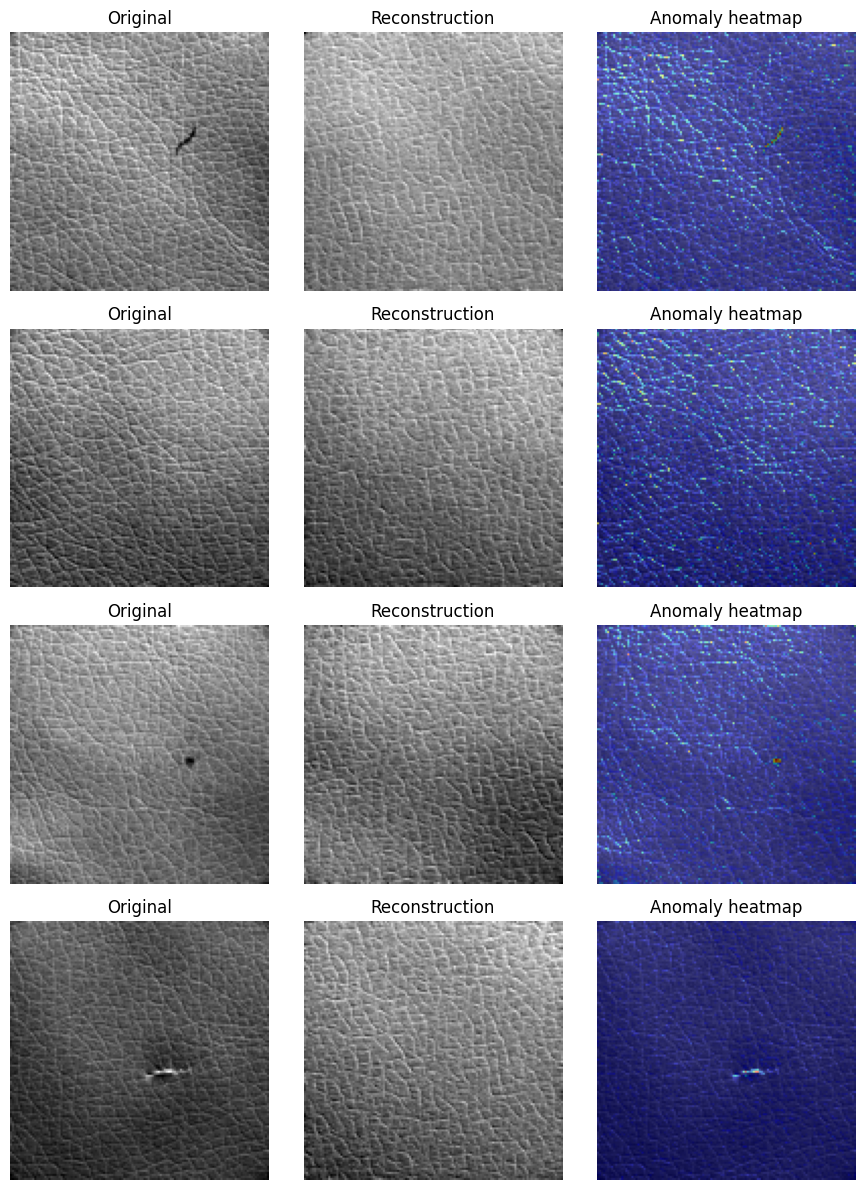

In [18]:
## Visualise results

from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
t_step = 45

x_test_batch, _ = next(iter(test_loader))
x_orig, x_recon, heatmap = v_reconstruct_and_heatmap(x_test_batch, t_step, num_steps = t_step)


B = x_orig.shape[0]
n_show = 4

plt.figure(figsize=(9, 3 * n_show))

for i in range(n_show):
    plt.subplot(n_show, 3, 3*i + 1)
    plt.imshow(x_orig[i].permute(1, 2, 0).numpy(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(n_show, 3, 3*i + 2)
    plt.imshow(x_recon[i].permute(1, 2, 0).numpy(), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

    plt.subplot(n_show, 3, 3*i + 3)
    img = x_orig[i].permute(1, 2, 0).numpy()
    hm  = heatmap[i].numpy()
    plt.imshow(img,cmap="gray")
    plt.imshow(hm, cmap="jet", alpha=0.5)  # overlay
    plt.title("Anomaly heatmap")
    plt.axis("off")

plt.tight_layout()
plt.show()


========== METRICS ==========
Mean-score  | AUROC: 0.6855 | AP: 0.8940
Patch-max   | AUROC: 0.9603 | AP: 0.9879

====== CONFUSION MATRIX (Patch-max) ======
Threshold: 0.000876
TP: 75 | FP: 1
FN: 17 | TN: 31


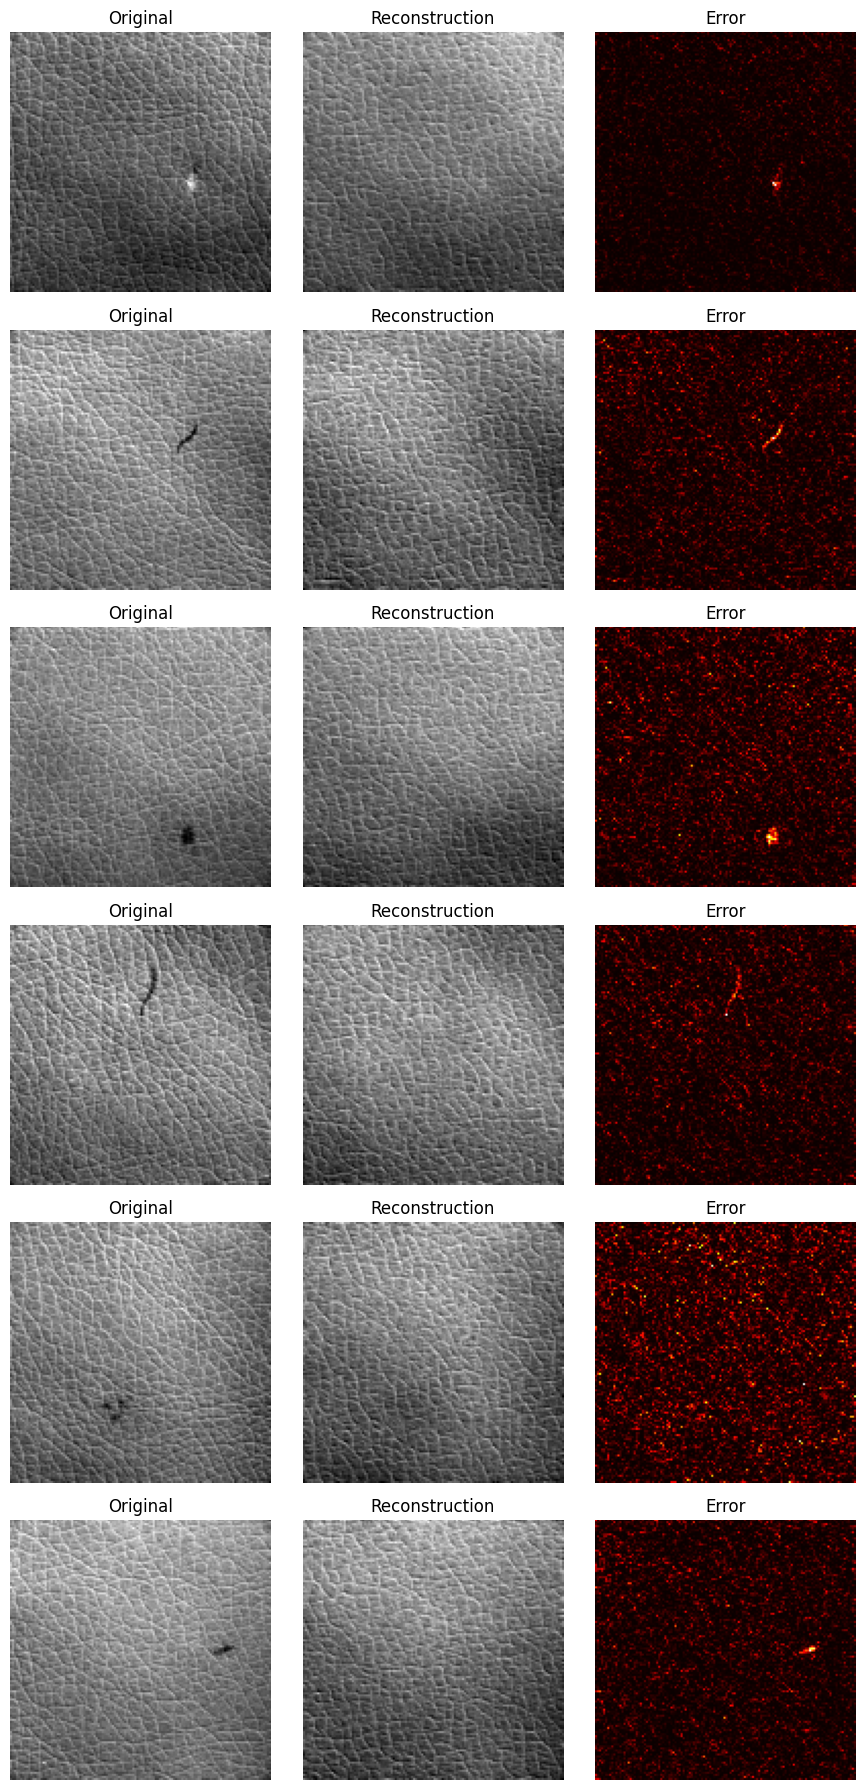

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# --------------------------------------------------
# Utilities
# --------------------------------------------------

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x

def ensure_hw_last(x):
    if x.ndim == 4 and x.shape[1] in [1,3]:
        x = np.transpose(x, (0,2,3,1))
    return x

# --------------------------------------------------
# Patch-max score
# --------------------------------------------------

def patch_max_score(pixel_err, patch_size=16):
    """
    pixel_err: [N,C,H,W]
    returns: [N]
    """
    err = pixel_err.mean(axis=1)  # [N,H,W]
    N, H, W = err.shape

    pad_h = (patch_size - H % patch_size) % patch_size
    pad_w = (patch_size - W % patch_size) % patch_size
    if pad_h or pad_w:
        err = np.pad(err, ((0,0),(0,pad_h),(0,pad_w)), mode="reflect")

    H2, W2 = err.shape[1:]
    err = err.reshape(
        N,
        H2 // patch_size, patch_size,
        W2 // patch_size, patch_size
    )

    patch_means = err.mean(axis=(2,4))  # [N,Hp,Wp]
    return patch_means.reshape(N, -1).max(axis=1)

# --------------------------------------------------
# Dataset Loader (copied from cell wxxrsDn8p2XC)
# --------------------------------------------------

class SimpleImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue

            label = 0 if class_name == "good" else 1

            for img_file in sorted(os.listdir(class_path)):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.paths.append(os.path.join(class_path, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return {
            "image": img,
            "label": self.labels[idx],
            "path": p
        }

# CONFIG (copied from cell wxxrsDn8p2XC)
IMG_SIZE = 128
TEST_DIR = "/content/leather/test"
BATCH = 8

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

dataset = SimpleImageFolder(TEST_DIR, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH, shuffle=False)

# --------------------------------------------------
# Evaluation loop
# --------------------------------------------------

all_preds, all_targets, all_labels = [], [], []

with torch.no_grad():
    for batch in loader:
        x = batch["image"].to(device)          # [B,C,H,W] in [0,1]
        y = np.array(batch["label"])           # [B]

        # ---- reconstruction ----
        _, x_recon, _ = v_reconstruct_and_heatmap(
            x, start_t=15, num_steps=15
        )

        all_preds.append(to_numpy(x_recon))
        all_targets.append(to_numpy(x))
        all_labels.append(y)

preds = np.concatenate(all_preds, axis=0)
targets = np.concatenate(all_targets, axis=0)
labels = np.concatenate(all_labels, axis=0)

# --------------------------------------------------
# Metrics
# --------------------------------------------------

pixel_err = (preds - targets) ** 2

mean_scores = pixel_err.mean(axis=(1,2,3))
patch_scores = patch_max_score(pixel_err, patch_size=16)

auroc_mean = roc_auc_score(labels, mean_scores)
ap_mean = average_precision_score(labels, mean_scores)

auroc_patch = roc_auc_score(labels, patch_scores)
ap_patch = average_precision_score(labels, patch_scores)

print("========== METRICS ==========")
print(f"Mean-score  | AUROC: {auroc_mean:.4f} | AP: {ap_mean:.4f}")
print(f"Patch-max   | AUROC: {auroc_patch:.4f} | AP: {ap_patch:.4f}")

# --------------------------------------------------
# Confusion Matrix (Patch-max, fixed threshold)
# --------------------------------------------------
# Use a simple threshold: mean + 3*std of normal scores
normal_scores = patch_scores[labels == 0]
threshold = normal_scores.mean() + 3.0 * normal_scores.std()

pred_labels = (patch_scores >= threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(labels, pred_labels).ravel()

print("\n====== CONFUSION MATRIX (Patch-max) ======")
print(f"Threshold: {threshold:.6f}")
print(f"TP: {tp} | FP: {fp}")
print(f"FN: {fn} | TN: {tn}")

# --------------------------------------------------
# Visualization
# --------------------------------------------------

def show_examples(inputs, recons, n=6):
    inputs = ensure_hw_last(inputs)
    recons = ensure_hw_last(recons)

    n = min(n, inputs.shape[0])
    plt.figure(figsize=(9, 3*n))

    for i in range(n):
        err = ((recons[i] - inputs[i])**2).mean(axis=2)
        err = (err - err.min()) / (err.max() - err.min() + 1e-9)

        plt.subplot(n,3,3*i+1)
        plt.imshow(inputs[i], cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(n,3,3*i+2)
        plt.imshow(recons[i], cmap="gray")
        plt.title("Reconstruction")
        plt.axis("off")

        plt.subplot(n,3,3*i+3)
        plt.imshow(err, cmap="hot")
        plt.title("Error")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_examples(targets, preds, n=6)
